In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def timeseries_bootstrap(tseries, block_size, seed=None):
    """
    Generates a bootstrap sample derived from the input time-series.
    Utilizes Circular-block-bootstrap method described in [1]_.

    Parameters
    ----------
    tseries : array_like
        A matrix of shapes (`M`, `N`) with `M` timepoints and `N` variables
    block_size : integer
        Size of the bootstrapped blocks
    random_state : integer
        the random state to seed the bootstrap

    Returns
    -------
    bseries : array_like
        Bootstrap sample of the input timeseries


    References
    ----------
    .. [1] P. Bellec; G. Marrelec; H. Benali, A bootstrap test to investigate
       changes in brain connectivity for functional MRI. Statistica Sinica,
       special issue on Statistical Challenges and Advances in Brain Science,
       2008, 18: 1253-1268.

    Examples
    --------

    >>> x = np.arange(50).reshape((5, 10)).T
    >>> sample_bootstrap(x, 3)
    array([[ 7, 17, 27, 37, 47 ],
           [ 8, 18, 28, 38, 48 ],
           [ 9, 19, 29, 39, 49 ],
           [ 4, 14, 24, 34, 44 ],
           [ 5, 15, 25, 35, 45 ],
           [ 6, 16, 26, 36, 46 ],
           [ 0, 10, 20, 30, 40 ],
           [ 1, 11, 21, 31, 41 ],
           [ 2, 12, 22, 32, 42 ],
           [ 4, 14, 24, 34, 44 ]])

    """
    import numpy as np

    if not seed:
        random_state = np.random.RandomState()
    else:
        random_state = np.random.RandomState(seed)

    # calculate number of blocks
    k = int(np.ceil(float(tseries.shape[0]) / block_size))

    # generate random indices of blocks
    r_ind = np.floor(random_state.rand(1, k) * tseries.shape[0])
    blocks = np.dot(np.arange(0, block_size)[:, np.newaxis], np.ones([1, k]))

    block_offsets = np.dot(np.ones([block_size, 1]), r_ind)
    block_mask = (blocks + block_offsets).flatten('F')[:tseries.shape[0]]
    block_mask = np.mod(block_mask, tseries.shape[0])

    #return tseries[block_mask.astype('int'), :], block_mask.astype('int')
    
    ################# modified the function to return vector of correlaiton matrix, instead of the time*parcel data.
    data=tseries[block_mask.astype('int'), :]
    data_corr=np.corrcoef(np.transpose(data))
    data_corr=upper_tri_indexing(data_corr)
    return data_corr


def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

def vec2symMat(vect,n):
    mat=np.zeros(shape=(n,n))
    pre=0
    for i in range(0,n):
        mat[i,i]=1
        if i != (n-1):
            mat[i,(i+1):n] = vect[pre:(pre+n-i-1)]
            mat[(i+1):n,i] = vect[pre:(pre+n-i-1)]
            pre=(pre+n-i-1)
    return mat

0.1601877903833808


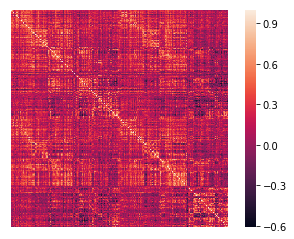

In [8]:
# Correlation matrix without Bagging
datain='209228_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean_flt.10k.dtseries_TS_Parcel.txt'
data=np.loadtxt(datain,delimiter=',')
#data=data[0:400,:]

# correlaiton matrix without bagging:
data_corr=np.corrcoef(data.T)
#data_corr=upper_tri_indexing(data_corr)
sns.heatmap(data_corr,square=True,xticklabels='',yticklabels='')
print(np.mean(data_corr))

0.1546843506750415


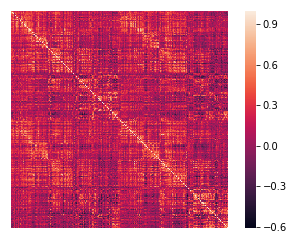

In [10]:
# Time series Bagging 500 times
block_size=np.int(np.floor(np.sqrt(data.shape[0]))) # for time series bootstrap
for i in range(0,500):
    if i ==0:
        tmp = timeseries_bootstrap(data, block_size, seed=i)
    else:
        tmp = tmp + timeseries_bootstrap(data, block_size, seed=i)

data_ts=tmp/float(500)
data_ts_corr=vec2symMat(data_ts,998)

sns.heatmap(data_ts_corr,square=True,xticklabels='',yticklabels='')

print(np.mean(data_ts_corr))